In [1]:
import time
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import argparse

In [97]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [98]:
task_name = "two_moons"

device = "cpu"
fn = f"{task_name}"
cached_fn = f"{task_name}_marg_epoch=5000.nf"
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=2, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=29, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer):

In [112]:
task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

calibration_sims = 50_000
calibration_theta = prior.sample((sims,))
calibration_x = simulator(calibration_theta)
calibration_theta = calibration_theta[...,:2]

test_sim = 10_000
test_theta = prior.sample((test_sim,))
test_x = simulator(test_theta)
test_theta = test_theta[...,:2]

In [123]:
from sklearn.cluster import KMeans
import numpy as np

K = 5
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto").fit(calibration_x)

In [134]:
radii = []
for k in range(K):
    dists = np.linalg.norm(kmeans.cluster_centers_[k] - kmeans.cluster_centers_, axis=1) / 2
    radii.append(np.min(dists[dists != 0]))

In [143]:
test_labels = np.ones(test_x.shape[0]) * -1
for k in range(K):
    dists = np.linalg.norm(test_x - kmeans.cluster_centers_[k], axis=1)
    test_labels[dists < radii[k]] = k

(-1.5, 1.5)

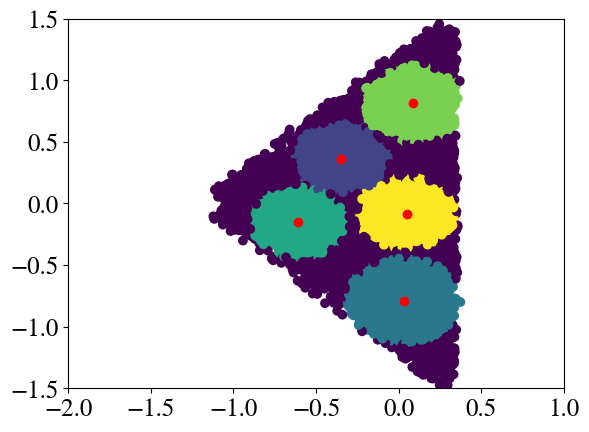

In [146]:
plt.scatter(test_x[:,0],test_x[:,1],c=test_labels.astype(float))
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c="r")
plt.xlim(-2.0, 1.0)
plt.ylim(-1.5, 1.5)

In [115]:
cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
desired_coverage = 0.95
conformal_quantile = np.quantile(cal_scores, q = desired_coverage)

In [116]:
probs = encoder.log_prob(test_theta.to(device), test_x.to(device)).detach().cpu().exp().numpy()

In [121]:
label_overall_covs = test_labels.copy().astype(float)
label_specific_covs = test_labels.copy().astype(float)

for k in range(K):
    conformal_quantile_k = np.quantile(cal_scores[kmeans.labels_ == k], q = desired_coverage)
    
    covered_overall_quantile = (1 / probs[test_labels == k]) < conformal_quantile
    label_overall_covs[test_labels == k] = np.sum(covered_overall_quantile) / len(covered_overall_quantile)

    covered_specific_quantile = (1 / probs[test_labels == k]) < conformal_quantile_k
    label_specific_covs[test_labels == k] = np.sum(covered_specific_quantile) / len(covered_specific_quantile)

In [122]:
print(np.unique(label_overall_covs))
print(np.unique(label_specific_covs))

[0.9305136  0.93729904 0.94103774 0.94471659 0.96451104 0.96527286
 0.96641478 0.9766537 ]
[0.9245283  0.94033233 0.94542877 0.94794953 0.95257235 0.95871239
 0.96557515 0.96653696]


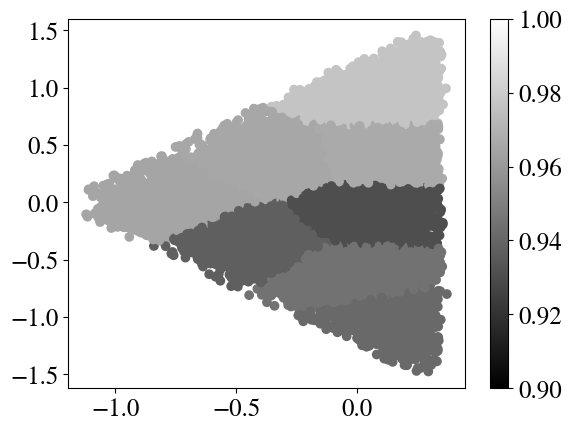

In [119]:
plt.scatter(test_x[:,0],test_x[:,1],c=label_overall_covs,cmap='gray',vmin=0.9, vmax=1.0)
plt.colorbar()

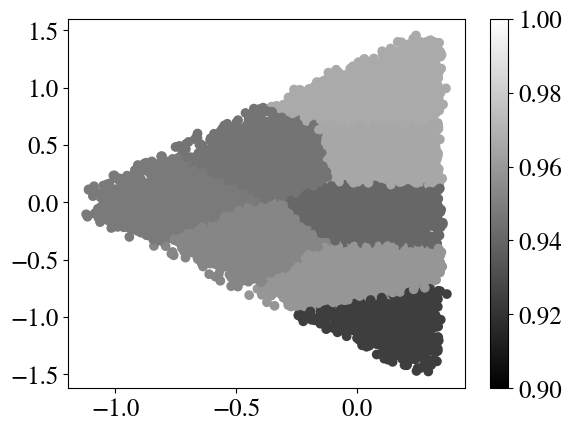

In [120]:
plt.scatter(test_x[:,0],test_x[:,1],c=label_specific_covs,cmap='gray',vmin=0.9, vmax=1.0)
plt.colorbar()